# Linear diffusion HW

Same imports from the main file 

In [1]:
# imports
import numpy as np
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim, xlim
import matplotlib.pyplot as plt
import copy

from landlab.plot.imshow import imshow_grid
from landlab import RasterModelGrid 
from landlab.components import LinearDiffuser
from landlab.components import TaylorNonLinearDiffuser
from landlab.components import FlowAccumulator

This is a sidenote of me trying to solve for the steady state solution, but I feel there's something wrong as the simulations don't reflect exactly these results.
- According to the notebook the defining equations being considered are:

    $$
    q_s = -D \left( 1 + \Big( \frac{S}{S_c} \Big)^2 \right)
    $$

    $$
    \frac{dz}{dt} = U-\nabla q_s
    $$

    Notice how the $q_s$ is always positive and, in particular being a quadratic, it has smaller values the closer $\frac{S}{S_c}$ to zero but also increasingly larger values the larger $\frac{S}{S_c}$ is from one. This means that transport capacity pass the critical slope is greatly increasing forcing the slopes to go back to near/under critical slope.

    If made into a one dimensional problem then the differential equation looks like

    $$
    \frac{dz}{dt} = U-\nabla q_s = U + \frac{2D}{S_c} \frac{S}{S_c}\frac{d S}{dx}.
    $$

    The steady state solution can be solved from the separable equation

    $$
    -\frac{U S_c^2}{2D} dx  =  S dS
    $$

    compacting the constants $C= \frac{U S_c^2}{D}$ and integrating once to solve the separable equation we get

    $$
    c_1 - \frac{C}{2} x  =  \frac{S^2}{2}
    $$

    solving for $S$ and using the fact that $S=-\frac{dz}{dx}$ we now need to solve

    $$
    \frac{dz}{dx} = \pm \sqrt{c_1-Cx}
    $$

    which solves as

    $$
    z = c_2 \pm \frac{2}{3C}(c_1-Cx)^{3/2}
    $$

    or

    $$
    z = c_2 \pm \frac{2}{3}(c_1-\sqrt[3]{C}x)^{3/2}
    $$

## 1. 

*From your experience with the linear diffusion model, you now know that if diffusivity is fixed, then a hillslope becomes steeper if the uplift/erosion rate is increased or the diffusivity is decreased.*

*Run a few model cases to illustrate the same behavior holds at steady state using the nonlinear diffusion model. Describe the model sensitivity to erosion rate and diffusivity using plots and text.*

- a little aux plot function to make things more readable and compact

In [43]:
def short_plot(elev_rast, **kwargs):
    """
    It plots the analytical solution stored in ys and zs.
    The input is a landlab raster grid model.

    **kwargs include:
    - title: string
        Title of the chart
    - percent: bool
        Misleadingly, if passed anything it will show the
        50% and 75% of the analytical solution. Don't pass an
        argument if you don't want it to show.
    - legend_loc: string
        A string argument to position the legend. See matplotlib
        legend() for documentation
    - show_analitical: bool
        Show the analitical solution of the linear diffuser
    """
    plot(ys_grid, elev_rast[:, 2], "r-", label="current model topography")
    if "show_analitical" in kwargs:
        if kwargs["show_analitical"]:
            plot(ys, zs, "k--", label="analytical solution")
    if "title" in kwargs:
        title(kwargs["title"])
    xlabel("horizontal distance (m)")
    ylabel("vertical distance (m)")
    if "percent" in kwargs:
        plot(ys, zs * 0.75, "b--", label="75% of analytical solution")
        plot(ys, zs * 0.5, "k--", label="50% of analytical solution")
    if "legend_loc" in kwargs:
        legend(loc=kwargs["legend_loc"])
    else:
        legend()
    show()


def short_subplot(elev_rast1, elev_rast2, ys_grid, ys=0, zs=0, **kwargs):
    """
    It plots the analytical solution stored in ys and zs.
    The input is a landlab raster grid model.

    **kwargs include:
    - title: string
        Title of the chart
    - legend_loc: string
        A string argument to position the legend. See matplotlib
        legend() for documentation
    - label1: string
        legend label 1
    - label2: string
        legend label 2  
    - show_analytical: bool
        Show the analitical solution of the linear diffuser
    """
    fig, axs = plt.subplots(2, sharex=True)
    label_1 = "half time solution"
    label_2 = "current solution"
    leg_loc = "upper right"
    if "legend_loc" in kwargs:
        leg_loc=kwargs["legend_loc"]
    if "label1" in kwargs:
        label_1=kwargs["label1"]
    if "label2" in kwargs:
        label_1=kwargs["label2"]
    axs[0].plot(ys_grid, elev_rast1[:, 2], "b-", label=label_1)
    axs[1].plot(ys_grid, elev_rast2[:, 2], "r-", label=label_2)
    if "show_analytical" in kwargs:
        if kwargs["show_analytical"]:
            axs[0].plot(ys, zs, "k--", label="analytical solution")
            axs[1].plot(ys, zs, "k--", label="analytical solution")
    if "title" in kwargs:
        plt.suptitle(kwargs["title"])
    axs[1].set(xlabel="horizontal distance (m)")
    axs[0].set(ylabel="elevation (m)")
    axs[1].set(ylabel="elevation (m)")
    axs[0].legend(loc=leg_loc)
    axs[1].legend(loc=leg_loc)
    show()

And a shorthand function for running multiple scenarios of uplift, diffusion and critical slope

In [44]:
def scenarios(Ds, uplift_rates, Scs, show_initial=False, show_analytical = False):
    """
    input for each parameter is a list of the multiple scenarios to be run
    """
    for Sc in Scs:
        for D in Ds:
            for uplift_rate in uplift_rates:
                # initialize model
                mg = RasterModelGrid((41, 5), 5.0)
                z_vals = mg.add_zeros("topographic__elevation", at="node")
                ycoord_rast = mg.node_vector_to_raster(mg.node_y)
                ys_grid = ycoord_rast[:, 2]
                mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
                nonlin_diffuse = TaylorNonLinearDiffuser(mg, linear_diffusivity=D, slope_crit=Sc, dynamic_dt=True)
                runtime = 1000000
                dt = 0.5 * mg.dx * mg.dx / D
                nt = int(runtime // dt)
                time_counter = 0
                uplift_per_step = uplift_rate * dt
                # analytical solution to linear diffuser
                ys = np.arange(mg.number_of_node_rows * mg.dx - mg.dx)
                divide_loc = (mg.number_of_node_rows * mg.dx - mg.dx) / 2
                half_width = (mg.number_of_node_rows * mg.dx - mg.dx) / 2
                zs = (uplift_rate / (2 * D)) * (np.power(half_width, 2) - np.power(ys - divide_loc, 2))
                # plot initial topography
                if show_initial:
                    figure()
                    elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
                    short_plot(
                        elev_rast, 
                        title ="initial topographic cross section")
                # run non linear diff half time and final solution
                for i in range(nt):
                    mg["node"]["topographic__elevation"][mg.core_nodes] += uplift_per_step
                    nonlin_diffuse.run_one_step(dt)
                    time_counter += dt
                    if i == int(nt // 2):
                        rast1 = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
                rast2 = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
                # plot both solutions
                short_subplot(
                    elev_rast1=rast1,
                    elev_rast2=rast2,
                    ys_grid=ys_grid,
                    zs=zs,
                    ys=ys,
                    title=f"topo c-section at times {int(time_counter // 2)} and {time_counter}, with D = {D}, uplift = {uplift_rate}, and S_c = {Sc}",
                    show_analytical = show_analytical,
                )

- Let's start by running multiple scenarios for uplift. We will use powers of 2 and fix the critical slope and the diffusion

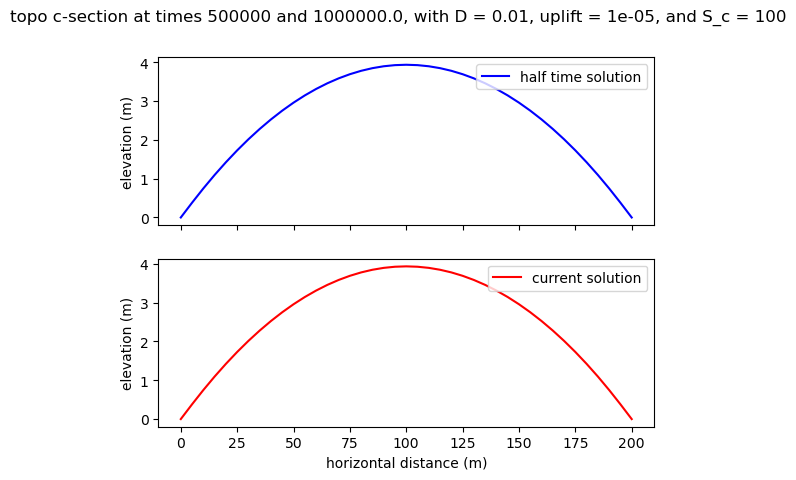

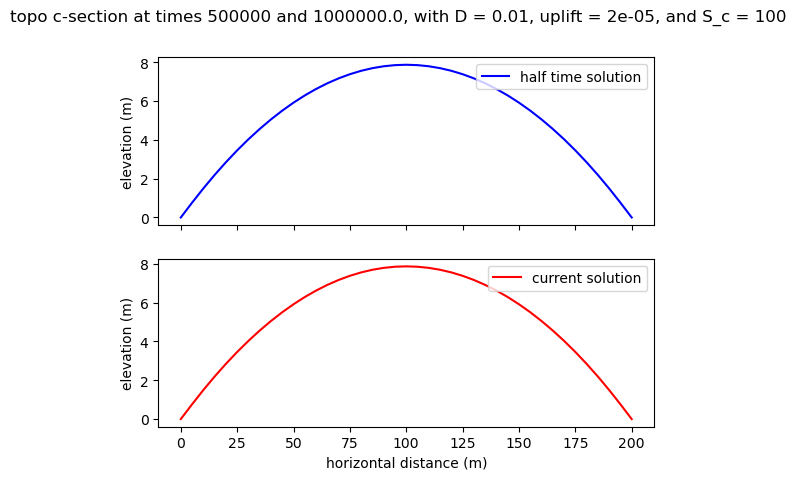

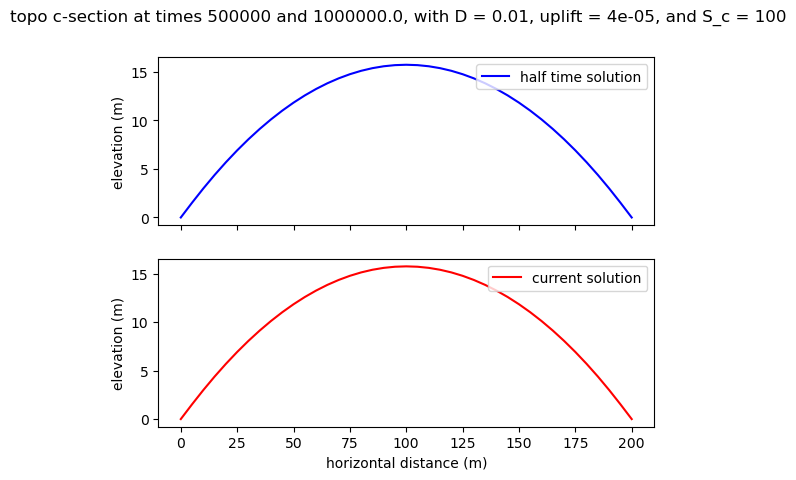

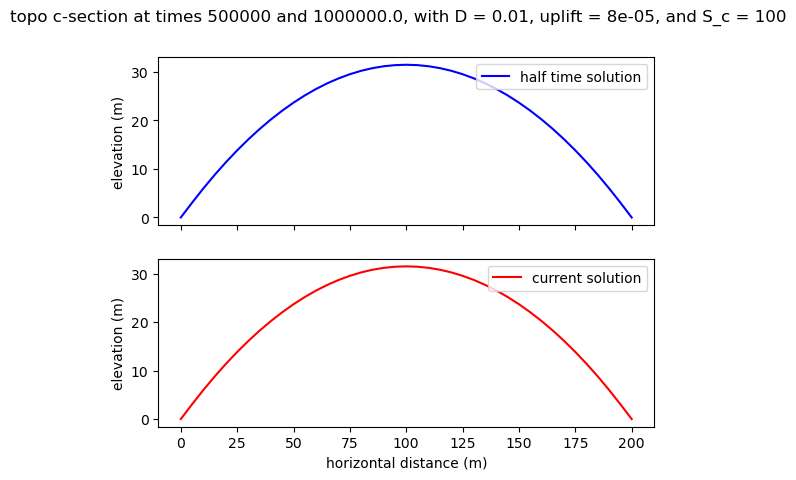

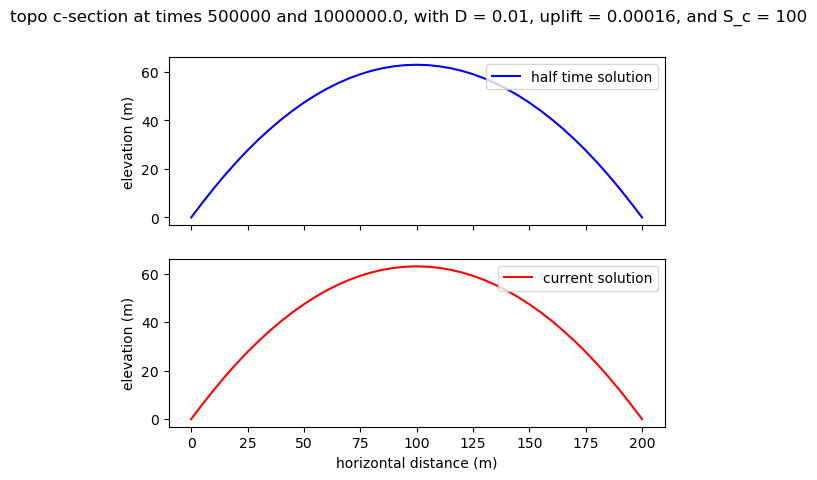

In [26]:
Ds = [0.01]
uplift_rates = [0.00001,0.00002,0.00004,0.00008,0.00016]
Scs = [100]
scenarios(Ds,uplift_rates,Scs)

- We see from these that the steady state solution scales almost linearly with the uplift rate.

    Now let's try the same but changing the diffusivity this time

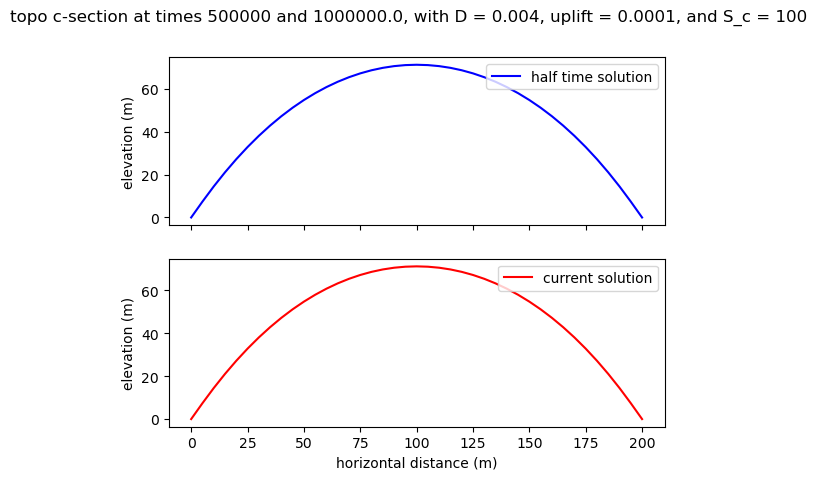

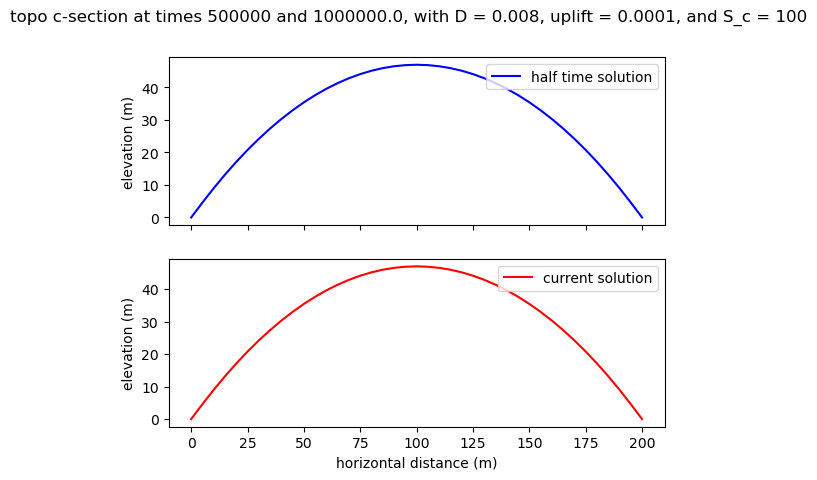

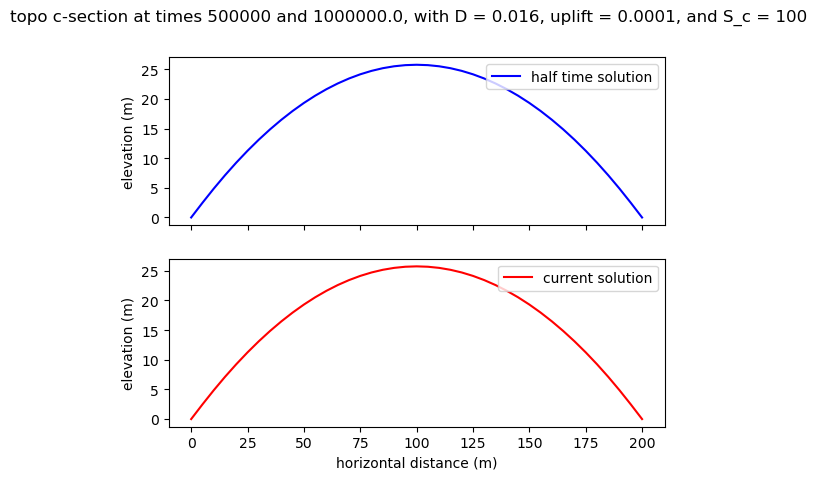

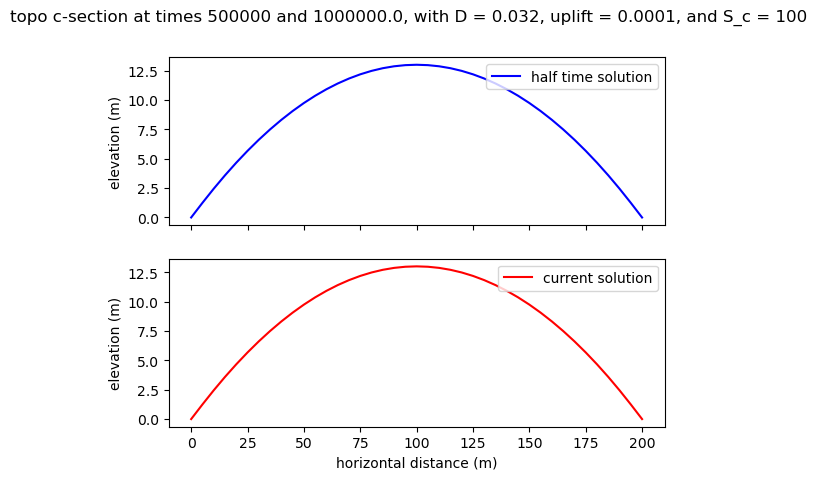

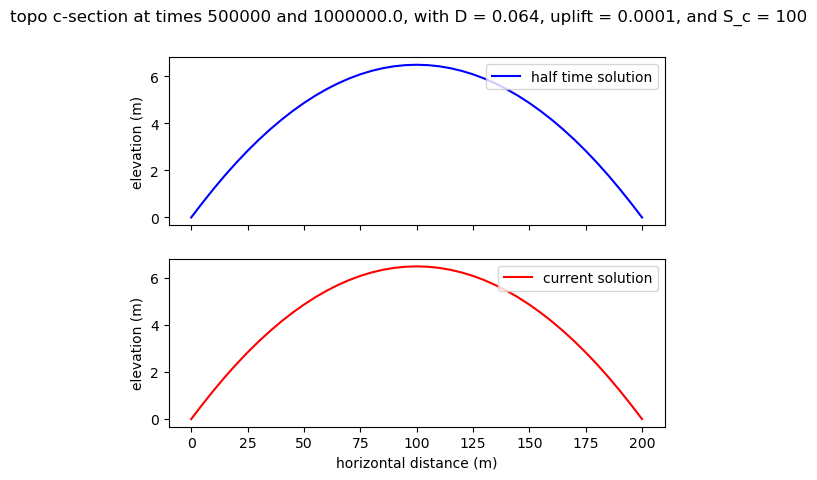

In [28]:
Ds = [0.004, 0.008, 0.016, 0.032, 0.064]
uplift_rates = [0.0001]
Scs = [100]
scenarios(Ds,uplift_rates,Scs)

- We see that the steady state solution scales almost inversely proportional to the diffusivity constant.


*Is the nonlinear model as sensitive to changes in these paramaters as the linear model? Make sure it is clear how you are making your assesment of what it means to be more or less sensitive.* 

- Yes, as I previously discussed, the change seems almost proportional to $\frac{E}{D}=\frac{U}{D}$ which is the same for the linear case (sensitivity in this case being a response measurement from changes in parameters of the stable solution, I refer specifically to the scale and shape of the solution).


and now we use a flow router to find the slopes

Text(0.5, 1.0, 'slope of the hillslope at time 1000000.0, with D = 0.01')

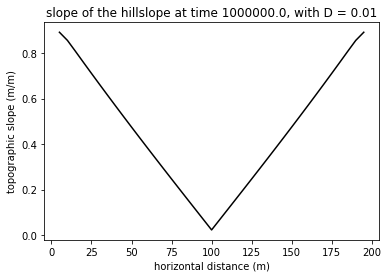

In [45]:
fr = FlowAccumulator(mg)
fr.run_one_step()
# plot slopes
plot(
    mg.node_y[mg.core_nodes],
    mg.at_node["topographic__steepest_slope"][mg.core_nodes],
    "k-",
)
xlabel("horizontal distance (m)")
ylabel("topographic slope (m/m)")
title(f"slope of the hillslope with S_c = {Sc}, and D = {D}")

## 2.

*How does changing $S_c$ impact hillslope form at steady state? Do some model runs to illustrate hillslope sensitivity to $S_c$.*

- I proceed in a similar way simulating scenarios but taking into account a few details.
    1. Since the critical slope represents the slope at which an increase of transport should happen then it is unlikely that results will reflect if the topography cannot attain slopes near critical. I therefore use a scenario in which those critical slopes are attain.
    2. From the equations in part 1, even if wrong, the constant coefficient has a $S_c^2$ suggesting that a steady state solution  will be impacted on the square or squareroot of the scale of $S_c$.

    Let's start by creating a scenario and estimating the slopes ranges.

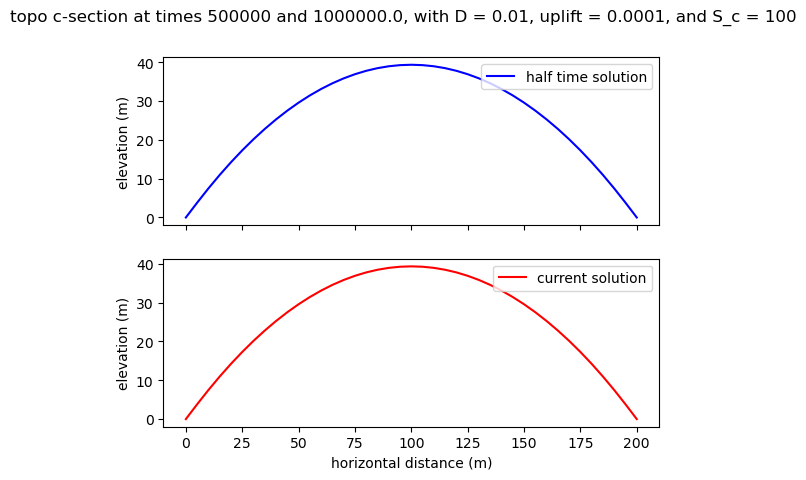

In [29]:
Ds = [0.01]
uplift_rates = [0.0001]
Scs = [100]
scenarios(Ds,uplift_rates,Scs)

By the mean value theorem, there should be slopes of roughly $S\approx \frac{40}{100}=0.4$ so I'll set the critical slope range around that and fix the other two parameters.

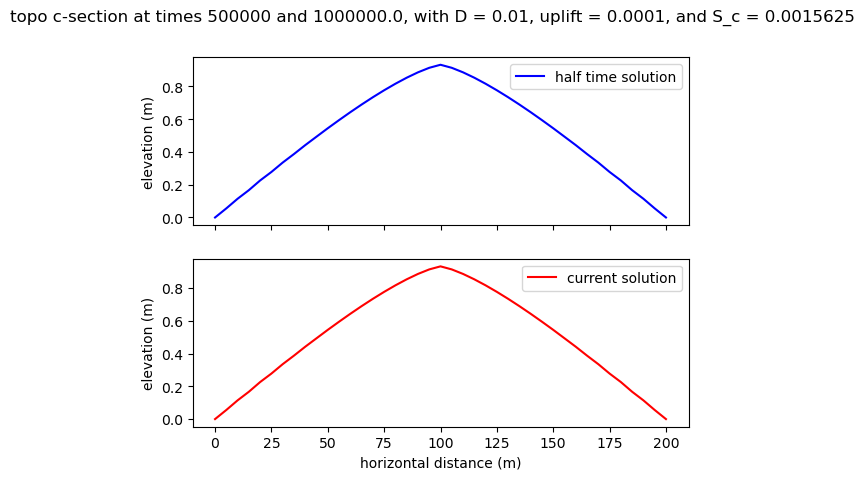

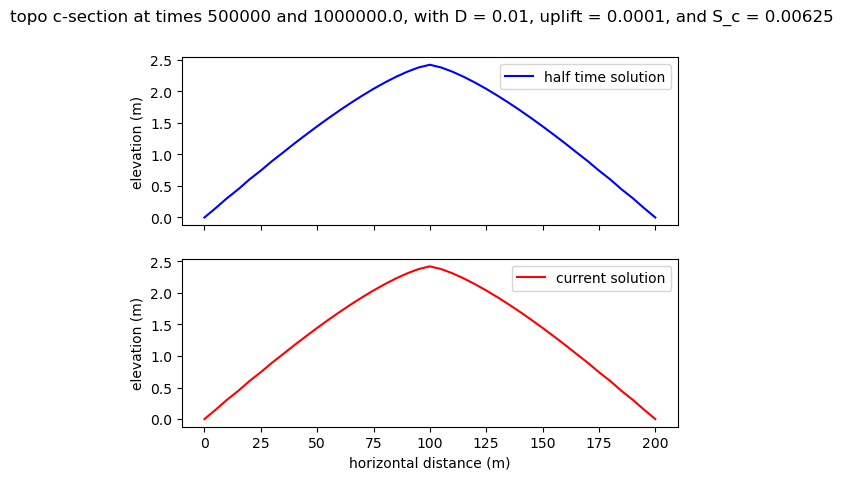

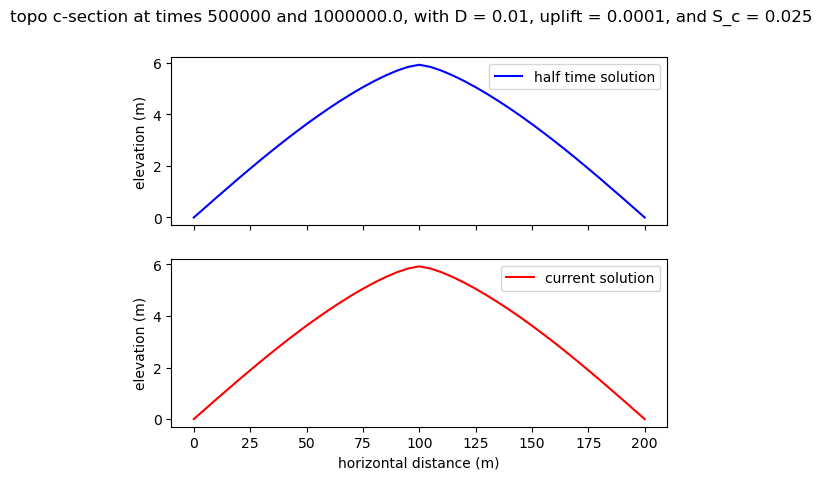

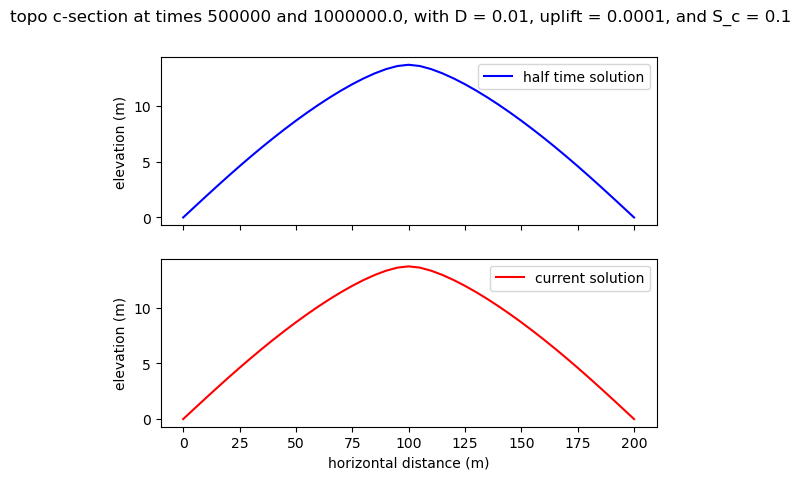

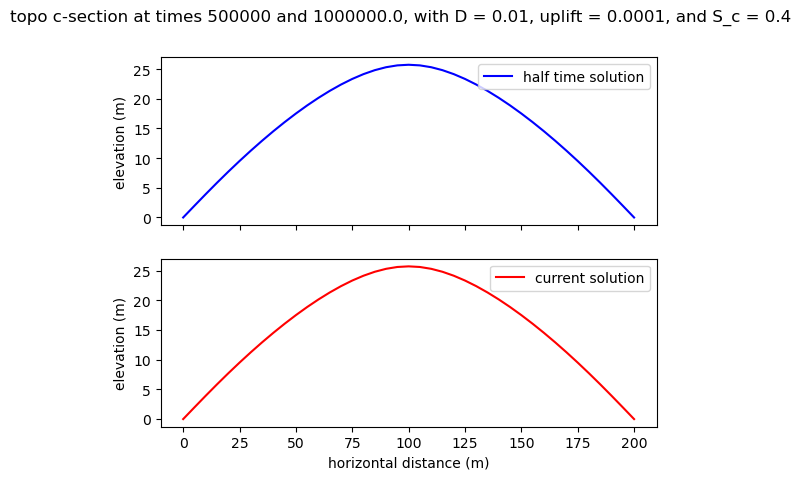

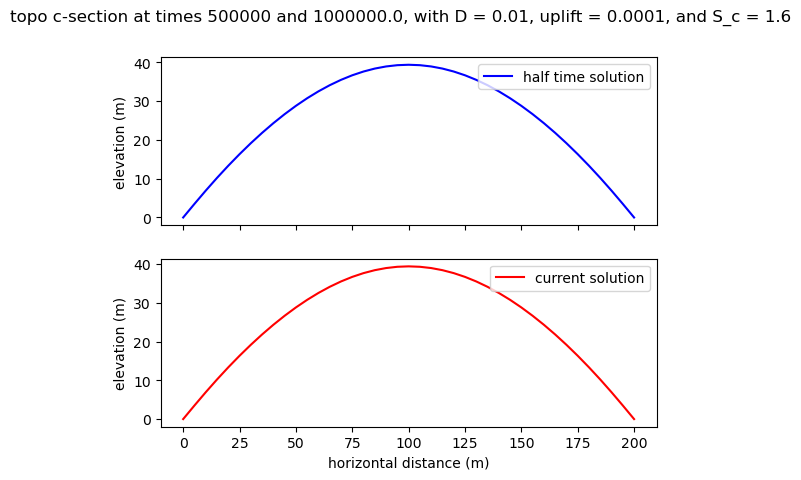

In [35]:
Ds = [0.01]
uplift_rates = [0.0001]
Scs = [0.4/256, 0.4/64,0.4/16, 0.4/4, 0.4, 0.4*4]
scenarios(Ds,uplift_rates,Scs)

That actually took its time to run. But as we can see when significantly below the critical slope, the slopes tend to be more constant and likely near $S_c$ as they can't go over the critical slope and stagnate. This also impacts the relief as not being able to sustain steep slopes means that the topography can't go up too fast. 

As expected, on the scales where the critical slope is significant, the steady state solution scales roughly with $\sqrt{S_c}$. After it stops being significant the solution doesn't change by increasing the critical slope anymore.

## 3. 
*If relief is defined as the difference between maximum and minimum elevation, do hillslopes evolved with the linear or nonlinear model have more relief? Compare hillslopes with the same $D$ value between the two models.*

- From the previous two questions I can conclude that the overall relief of the non linear diffuser will be less than in the linear case, but also that the relief will be greatly limited by the critical slope. I will do one last set of plots to illustrate this while showing the analytical solution 

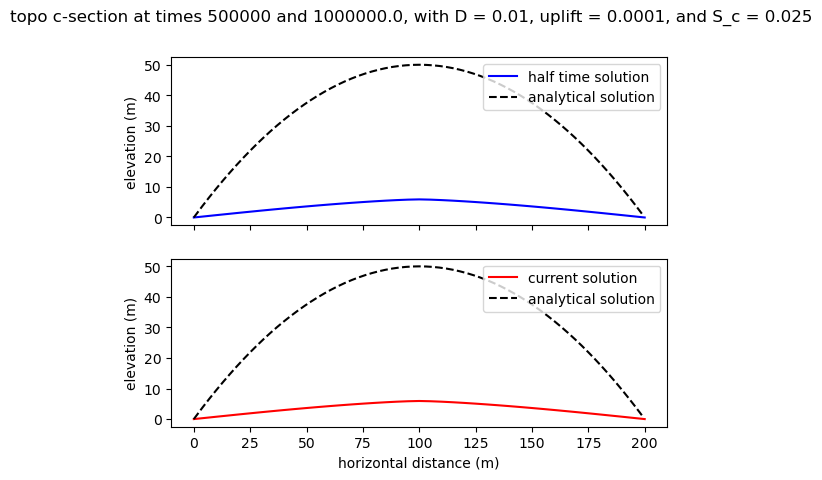

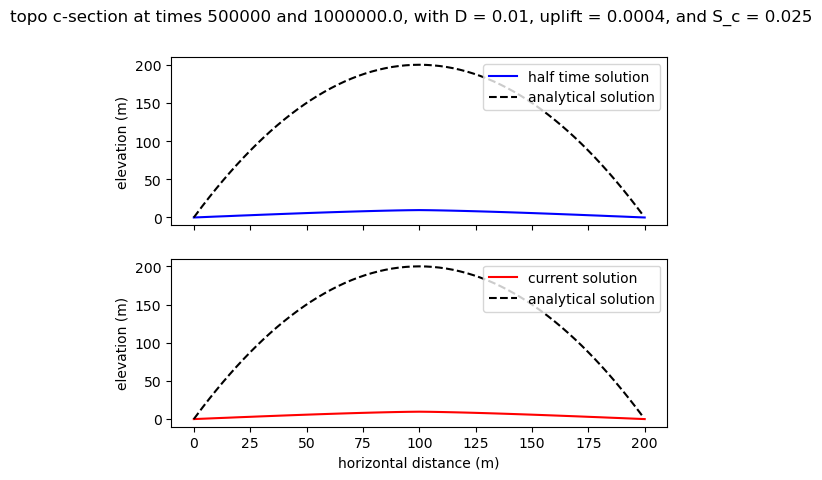

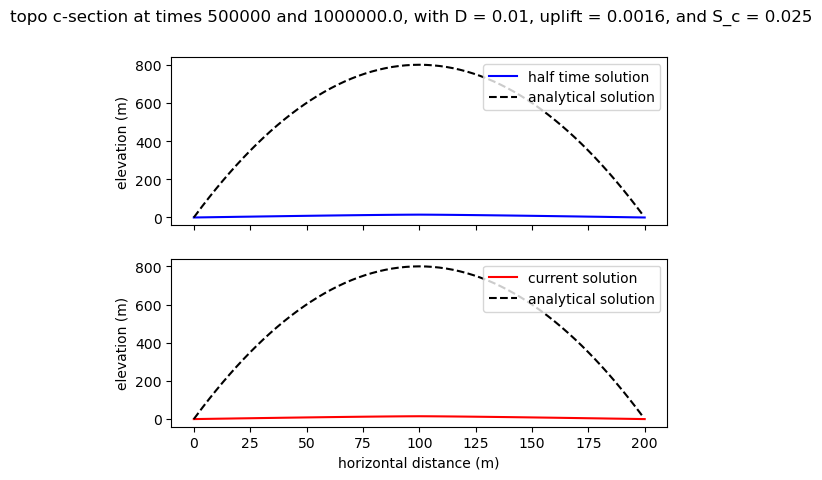

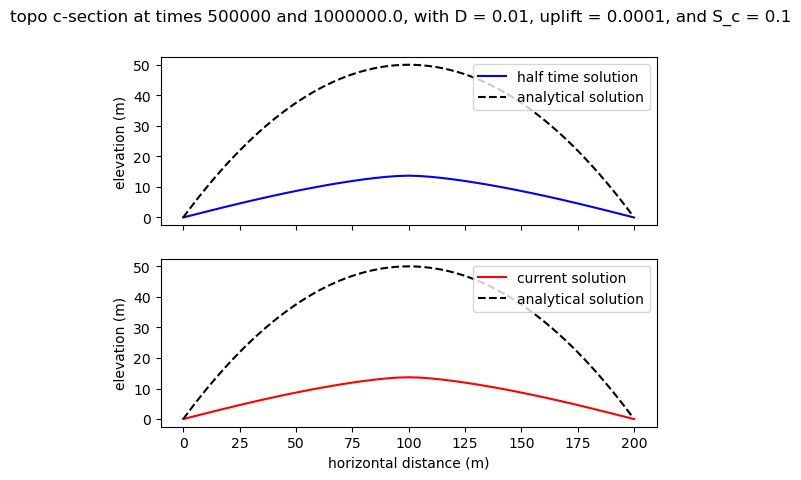

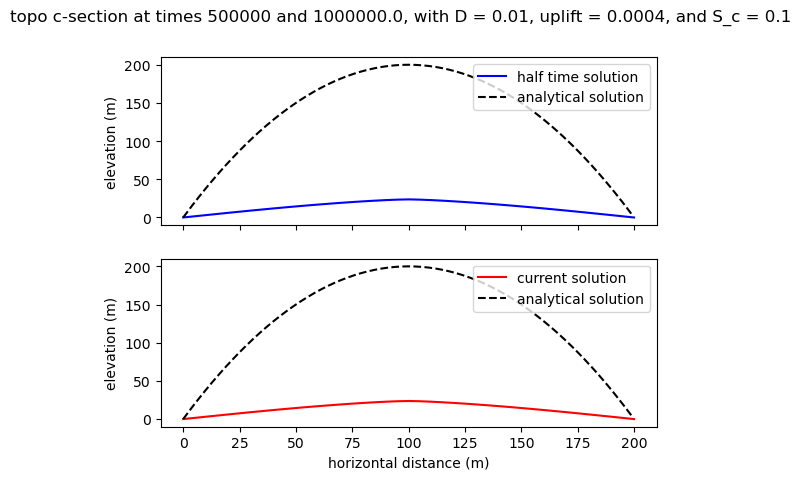

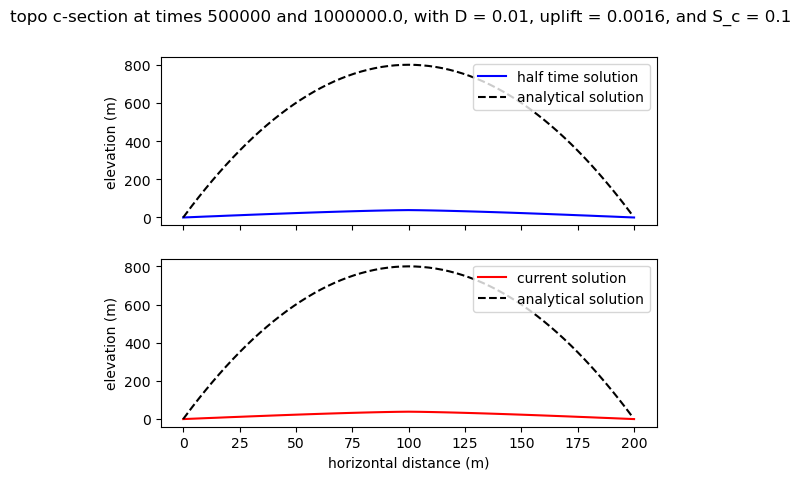

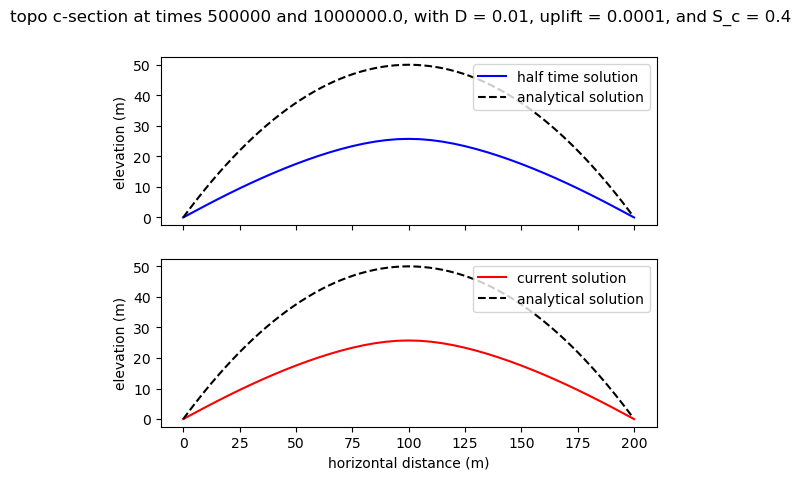

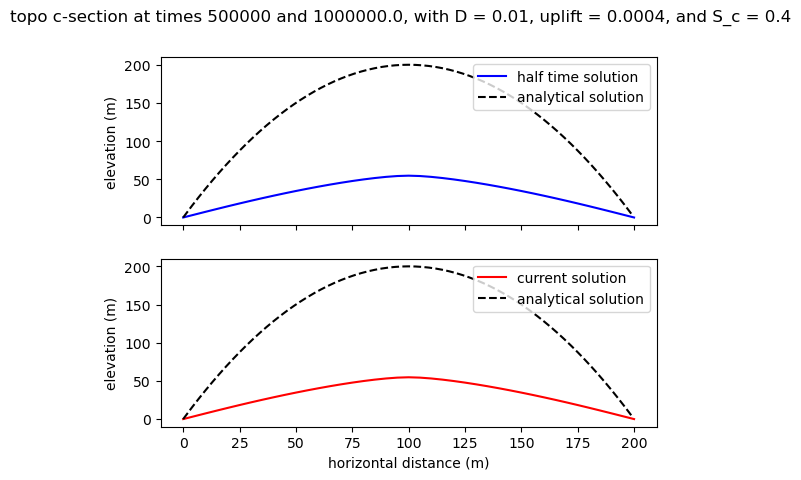

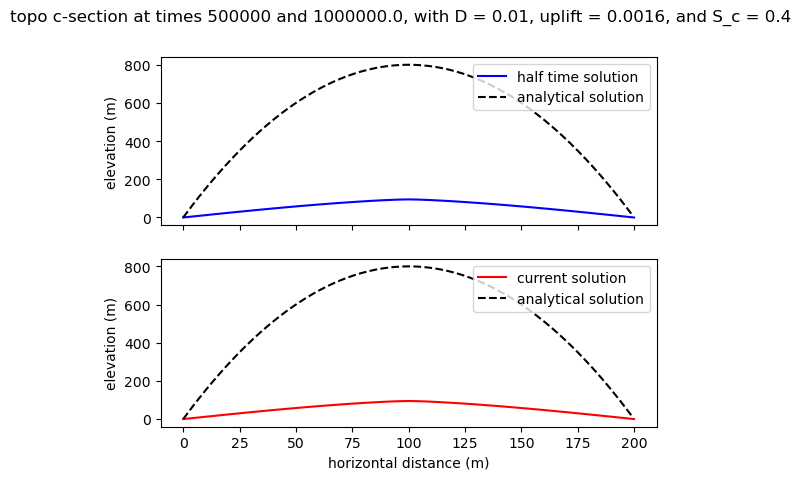

In [50]:
Ds = [0.01]
uplift_rates = [0.0001, 0.0004, 0.0016]
Scs = [0.4/16, 0.4/4, 0.4]
scenarios(Ds, uplift_rates, Scs, show_initial=False, show_analytical = True)